<a href="https://colab.research.google.com/github/rohts-patil/VQA-Med-2019/blob/master/notebooks/VQA_Organ_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/VQA

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/VQA


In [0]:
import glob
import random

import numpy as np
import pandas as pd

import time
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import LabelEncoder
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [0]:
path =r'train/QAPairsByCategory'

filenames = glob.glob(path + "/*.txt")

dfs = []

for filename in filenames:
    df_temp = pd.read_csv(filename,delimiter='|',names=['id','question','answer'])
    df_temp['label'] = df_temp.apply(lambda x: ((filename.split('/')[-1].replace('_train.txt',''))), axis=1)
    dfs.append(df_temp)

df_train = pd.concat(dfs, ignore_index=True)

In [4]:
df_train.head()

,id,question,answer,label
0,synpic41148,what kind of image is this?,cta - ct angiography,C1_Modality
1,synpic43984,is this a t1 weighted image?,no,C1_Modality
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,C1_Modality
3,synpic52143,is this a noncontrast mri?,no,C1_Modality
4,synpic20934,what type of image modality is this?,xr - plain film,C1_Modality


In [0]:
path =r'val/QAPairsByCategory'

filenames = glob.glob(path + "/*.txt")

dfs = []

for filename in filenames:
    df_temp = pd.read_csv(filename,delimiter='|',names=['id','question','answer'])
    df_temp['label'] = df_temp.apply(lambda x: (filename.split('/')[-1].replace('_val.txt','')), axis=1)
    dfs.append(df_temp)

df_valid = pd.concat(dfs, ignore_index=True)

In [6]:
df_valid.head()

,id,question,answer,label
0,synpic54733,what imaging modality was used to take this im...,ct with iv contrast,C1_Modality
1,synpic25647,what kind of scan is this?,xr - plain film,C1_Modality
2,synpic35681,was the mri taken with contrast?,no,C1_Modality
3,synpic39641,"is this a t1 weighted, t2 weighted, or flair i...",t2,C1_Modality
4,synpic35693,is this a noncontrast mri?,yes,C1_Modality


In [7]:
df_train = df_train[df_train['label'] == 'C3_Organ']
df_train.head()

,id,question,answer,label
6400,synpic41148,which organ is captured by this ct scan?,"lung, mediastinum, pleura",C3_Organ
6401,synpic43984,what organ system is primarily present in this...,skull and contents,C3_Organ
6402,synpic38930,which organ system is imaged?,genitourinary,C3_Organ
6403,synpic52143,the mri shows what organ system?,spine and contents,C3_Organ
6404,synpic20934,what organ system is shown in this x-ray?,spine and contents,C3_Organ


In [8]:
df_valid = df_valid[df_valid['label'] == 'C3_Organ']
df_valid.head()

,id,question,answer,label
1000,synpic54733,what organ system is shown in the image?,"face, sinuses, and neck",C3_Organ
1001,synpic25647,what organ system is being imaged?,"lung, mediastinum, pleura",C3_Organ
1002,synpic35681,what part of the body is being imaged?,breast,C3_Organ
1003,synpic39641,what organ system is pictured here?,musculoskeletal,C3_Organ
1004,synpic35693,what is the organ principally shown in this mri?,heart and great vessels,C3_Organ


In [9]:
labelencoder = LabelEncoder()
df_train['organ_type'] = labelencoder.fit_transform(df_train['answer'])
df_train.head()

,id,question,answer,label,organ_type
6400,synpic41148,which organ is captured by this ct scan?,"lung, mediastinum, pleura",C3_Organ,5
6401,synpic43984,what organ system is primarily present in this...,skull and contents,C3_Organ,7
6402,synpic38930,which organ system is imaged?,genitourinary,C3_Organ,3
6403,synpic52143,the mri shows what organ system?,spine and contents,C3_Organ,8
6404,synpic20934,what organ system is shown in this x-ray?,spine and contents,C3_Organ,8


In [10]:
df_valid['organ_type'] = labelencoder.fit_transform(df_valid['answer'])
df_valid.head()

,id,question,answer,label,organ_type
1000,synpic54733,what organ system is shown in the image?,"face, sinuses, and neck",C3_Organ,1
1001,synpic25647,what organ system is being imaged?,"lung, mediastinum, pleura",C3_Organ,5
1002,synpic35681,what part of the body is being imaged?,breast,C3_Organ,0
1003,synpic39641,what organ system is pictured here?,musculoskeletal,C3_Organ,6
1004,synpic35693,what is the organ principally shown in this mri?,heart and great vessels,C3_Organ,4


In [11]:
integer_mapping = {l: i for i, l in enumerate(labelencoder.classes_)}
integer_mapping

{'breast': 0,
 'face, sinuses, and neck': 1,
 'gastrointestinal': 2,
 'genitourinary': 3,
 'heart and great vessels': 4,
 'lung, mediastinum, pleura': 5,
 'musculoskeletal': 6,
 'skull and contents': 7,
 'spine and contents': 8,
 'vascular and lymphatic': 9}

In [0]:
class OrganDataSet(Dataset):
    def __init__(self, image_names,organ_types, root_dir, transform=None):
        self.image_names = image_names
        self.organ_types = organ_types
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = '{}.jpg'.format(self.image_names[idx])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.organ_types[idx]
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [0]:
organ_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
train_ds = OrganDataSet(df_train['id'].values,df_train['organ_type'].values, r'train/Train_images/', transform=organ_trans)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

organ_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
train_ds = OrganDataSet(df_train['id'].values,df_train['organ_type'].values, r'train/Train_images/', transform=organ_trans)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

valid_ds = OrganDataSet(df_valid['id'].values,df_valid['organ_type'].values, r'val/Val_images/', transform=organ_trans)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

In [0]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224]) torch.Size([4])


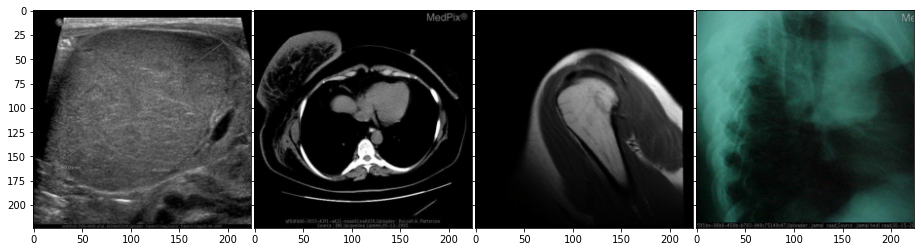

In [15]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224]) torch.Size([4])


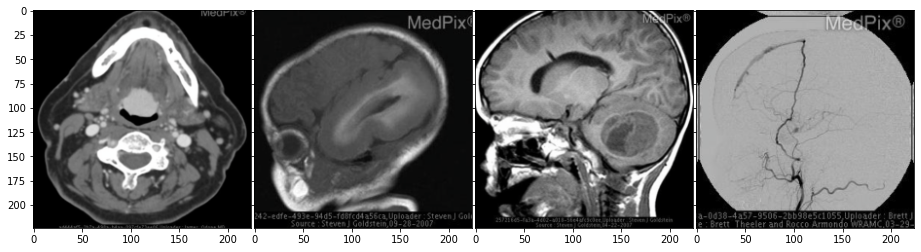

In [16]:
img, label = next(iter(valid_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [0]:
model = models.resnet50(pretrained=True)

In [0]:
use_gpu = torch.cuda.is_available()
model = model.cuda()

In [0]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [0]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [26]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch [0/1] train loss: 0.5103 acc: 0.0000 valid loss: 0.3828 acc: 0.0000
Epoch [1/1] train loss: 0.3841 acc: 0.0000 valid loss: 0.3775 acc: 0.0000
Best val Acc: 0.000000
Training time:   9.108905 minutes
